In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,BatchNormalization
from tensorflow import keras

note that change the data source


In [2]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\saved_data.csv")

In [3]:
time=data['Date']
data=data.drop('Date', axis=1)
target="BTC_close"


In [4]:
data.head()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
0,0.1,0.1,0.1,0.1,0.26,936.0,182.0,1090.745856,789700.0,0.000000,...,0.0,0.0,0.0,0.0,1191.7,17.693,0.00,1083.48,10229.96,9300.46
1,0.1,0.1,0.1,0.1,0.58,784.0,182.0,603.821256,499964.0,0.000000,...,0.0,0.0,0.0,0.0,1191.8,17.803,0.00,1069.59,10120.53,9278.83
2,0.1,0.1,0.1,0.1,2.16,594.0,182.0,572.443182,403000.0,0.000000,...,0.0,0.0,0.0,0.0,1195.6,18.120,7002.75,1093.67,10322.30,9220.88
3,0.1,0.1,0.1,0.1,2.40,655.0,182.0,530.932990,412004.0,0.000606,...,0.0,0.0,0.0,0.0,1187.8,18.101,7018.25,1102.66,10424.62,9430.96
4,0.1,0.1,0.1,0.1,0.50,959.0,182.0,1519.539683,1148772.0,0.000000,...,0.0,0.0,0.0,0.0,1187.8,18.101,7018.25,1102.66,10424.62,9430.96


In [5]:
data.columns

Index(['BTC_close', 'BTC_open', 'BTC_high', 'BTC_low', 'BTC_volume',
       'Active_Addr_Cnt', 'Difficulty', 'Mean_Block_Size(in_bytes)',
       'Sum_Block_Weight', 'Total_Fees(USD)', 'Mean_Hashrate', 'Xfer_Cnt',
       'Mean_Tx_size(native_units)', 'ETH', 'LTC', 'DOGE', 'XRP', 'GOLD',
       'SILVER', 'COPPER', 'S&P500', 'DJI', 'JP225'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


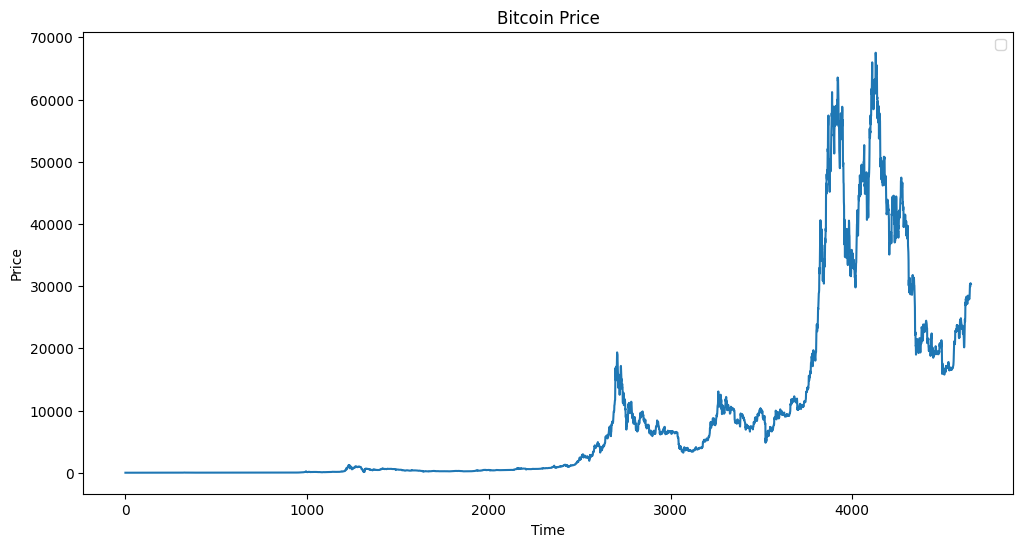

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(data[target])

plt.title('Bitcoin Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
target=np.array(target)
target.shape

()

splitting data to train, valid, test set

In [8]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [9]:
train_time=time[:int(0.7*len(data))]
val_time=time[int(0.7*len(data)):int(0.85*len(data))]
test_time=time[int(0.85*len(data)):]

In [10]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

In [40]:
time_step=40
train_time_line=[]
val_time_line=[]
test_time_line=[]

**Create data sequence, sequence length is time step and predict y is the right next day**

In [103]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    for i in range(len(df)-timesteps):    
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=df[i+timesteps].reshape(1,-1)
        value=scaler.transform(value)
        y.append(value[:,close_col_idx])

    return np.array(x),np.array(y),timeLine


In [104]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'))

**Build Model**

In [28]:

model = Sequential()
model.add(LSTM(units=100,return_sequences=True,recurrent_dropout=0.3))
model.add(LSTM(units=100,return_sequences =True,recurrent_dropout=0.3))
model.add(LSTM(units=64,return_sequences=False,recurrent_dropout=0.3))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
moniter=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
model.compile(optimizer='adam',loss='MeanSquaredError',metrics=['accuracy'])
model.fit(train_x,train_y,epochs=1, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])
model.summary()

101/101 [==============================] - 28s 189ms/step - loss: 0.0779 - accuracy: 0.0429 - val_loss: 0.0590 - val_accuracy: 0.0000e+00
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 40, 100)           49600     
                                                                 
 lstm_4 (LSTM)               (None, 40, 100)           80400     
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 173,297
Trainable params: 173,297


In [29]:
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=50, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])

Epoch 1/50
101/101 [==============================] - 25s 148ms/step - loss: 0.0445 - val_loss: 0.0312
Epoch 2/50
101/101 [==============================] - 14s 135ms/step - loss: 0.0304 - val_loss: 0.0448
Epoch 3/50
101/101 [==============================] - 12s 122ms/step - loss: 0.0269 - val_loss: 0.0241
Epoch 4/50
101/101 [==============================] - 11s 104ms/step - loss: 0.0246 - val_loss: 0.0239
Epoch 5/50
101/101 [==============================] - 10s 104ms/step - loss: 0.0235 - val_loss: 0.0245
Epoch 6/50
101/101 [==============================] - 12s 119ms/step - loss: 0.0227 - val_loss: 0.0248
Epoch 7/50
101/101 [==============================] - 10s 101ms/step - loss: 0.0225 - val_loss: 0.0227
Epoch 8/50
101/101 [==============================] - 10s 97ms/step - loss: 0.0218 - val_loss: 0.0218
Epoch 9/50
101/101 [==============================] - 10s 99ms/step - loss: 0.0214 - val_loss: 0.0225
Epoch 10/50
101/101 [==============================] - 10s 98ms/step - loss

In [30]:
model.evaluate(train_x,train_y)
model.evaluate(val_x,val_y)
model.evaluate(test_x,test_y)

21/21 [==============================] - 0s 21ms/step - loss: 0.0216


0.021624412387609482

In [31]:
predictions = model.predict(test_x)
test_y=test_y.reshape(-1,1)

21/21 [==============================] - 1s 17ms/step


In [32]:

test_y_reshape = test_y.reshape(-1)
predictions_reshape = predictions.reshape(-1)
mse = mean_squared_error(test_y_reshape, predictions_reshape)
mae = mean_absolute_error(test_y_reshape, predictions_reshape)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 0.021624412
Mean Absolute Error (MAE): 0.09770638


In [33]:

mean_absolute_percentage_error(test_y,predictions)

0.5030139

In [34]:
prec_train=model.predict(train_x)
pre_val=model.predict(val_x)

  1/101 [..............................] - ETA: 4s

21/21 [==============================] - 0s 17ms/step


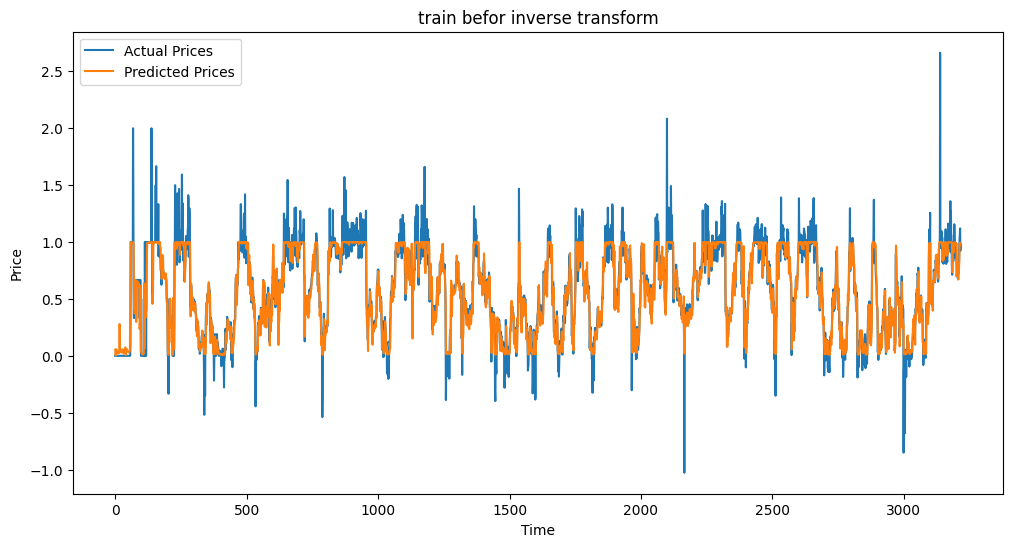

In [100]:
# Plot the predicted and actual prices
plt.figure(figsize=(12,6))
plt.plot(train_y, label='Actual Prices')
plt.plot(prec_train, label='Predicted Prices')

plt.title('train befor inverse transform')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

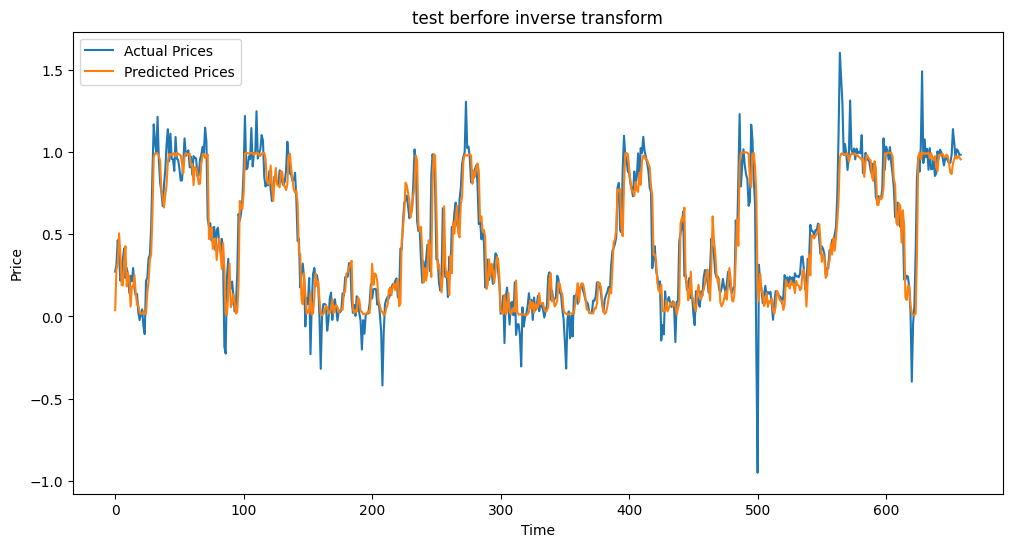

In [101]:

# Plot the predicted and actual prices
plt.figure(figsize=(12,6))
plt.plot(test_y, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')

plt.title('test berfore inverse transform')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [74]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return result


In [106]:
test_after_inverse=inverseTransform(predictions,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(prec_train,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

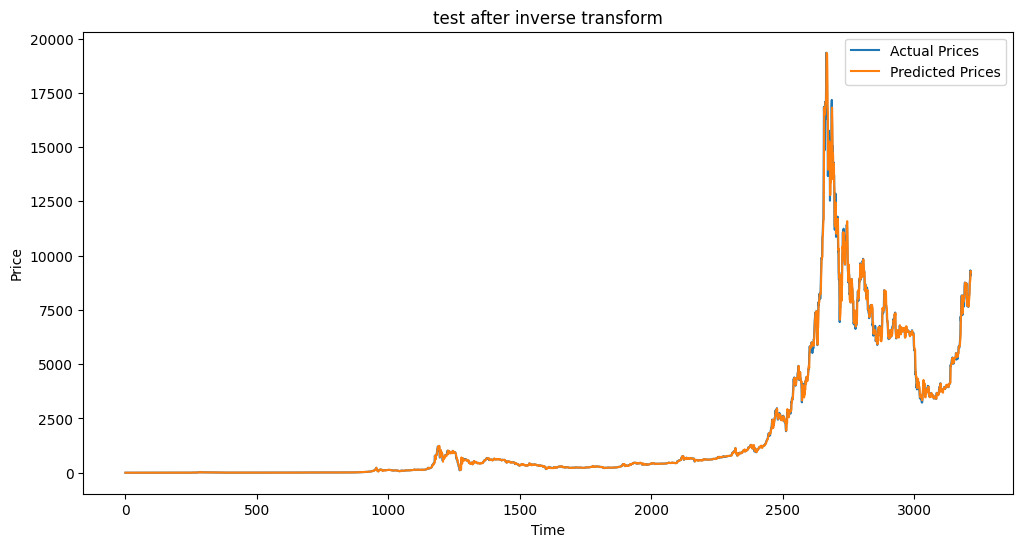

In [107]:

# Plot the predicted and actual prices
plt.figure(figsize=(12,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train after inverse transform')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

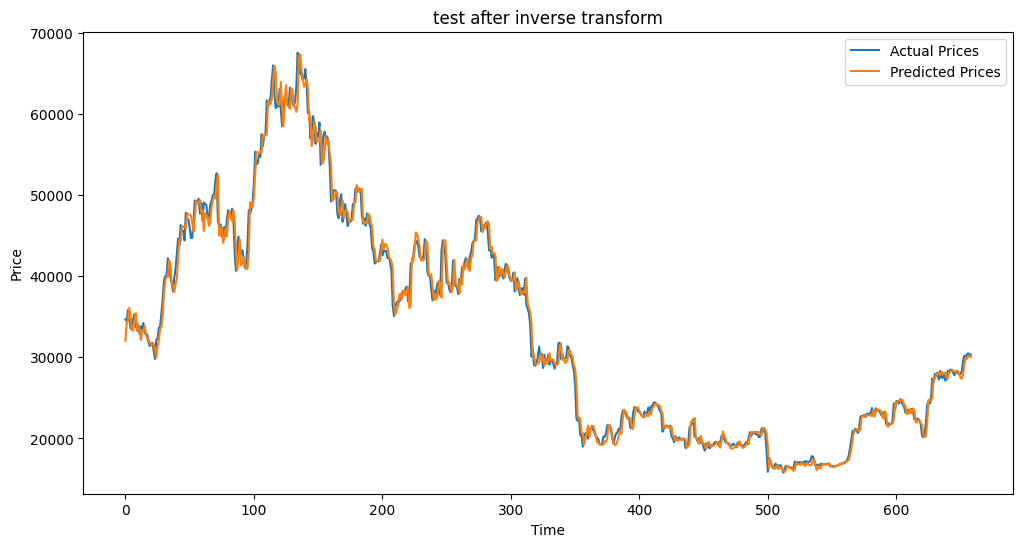

In [102]:

# Plot the predicted and actual prices
plt.figure(figsize=(12,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(test_after_inverse, label='Predicted Prices')

plt.title('test after inverse transform')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()